# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
# from sklearn.datasets import load_boston
# данный датасет был удален в версии 1.2 поэтому воспользовался подсказкой из сообщения
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [8]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

**В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!**

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [13]:
def compute_biase_variance(regressor, X, y, num_runs=1000): # внимание! данный алгоритм можно (нужно) оптимизировать, преобразуя второй цикл
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    comb = []
    bias = []
    varience = []
    for j in range(num_runs): # задаем выборки, модели и их предсказания на них
        indexes = np.random.choice(X.shape[0], size=X.shape[0]) # выбираем N элементов с возвращением (бутстрап)
        X_j = X[indexes] # подвыборка
        y_j = y[indexes]
        a_j = regressor.fit(X_j, y_j) # обучили модель
        out_of_bag = list(set(np.arange(X.shape[0])) - set(indexes))
        T_j = X[out_of_bag] # все, что не вошло в выборку
        comb += [dict(zip(out_of_bag, a_j.predict(T_j)))] # список наборов из индексов out of bag и предсказания модели j на них
    loss = np.mean(np.array([np.mean((np.array(list(dictionary.values())) - y[list(dictionary.keys())]) ** 2) for dictionary in comb])) # ошибка
    for j in range(X.shape[0]):
        answers_on_j = np.array([dictionary[j] for dictionary in comb if (j in dictionary.keys())]) # ответы моделей на j-ом объекте
        mean_predict = np.mean(answers_on_j)  # среднее предсказание по j-ому объекту
        bias += [(mean_predict - y[j]) ** 2]
        varience += [np.mean((answers_on_j - mean_predict) ** 2)]
    return np.array(bias).mean(), np.array(varience).mean(), loss

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

**Н** Внимание! данный код работает ~5-10 минут, необходимо запастись печеньками

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [18]:
import time # LinReg
start_time = time.time()
bias_1, varience_1, loss_1 = compute_biase_variance(LinearRegression(), X, y, num_runs=1000)
ex_time_1 = time.time() - start_time
print(bias_1, varience_1, bias_1 + varience_1, loss_1)
print('Execution time for Linear Regression: %f' % ex_time_1) 
print('-' * 80)

start_time = time.time() # Tree
bias_2, varience_2, loss_2 = compute_biase_variance(DecisionTreeRegressor(), X, y, num_runs=1000)
ex_time_2 = time.time() - start_time
print(bias_2, varience_2, bias_2 + varience_2, loss_2)
print('Execution time for Decision Tree: %f' % ex_time_2) 
print('-' * 80)

start_time = time.time() # Forest
bias_3, varience_3, loss_3 = compute_biase_variance(RandomForestRegressor(), X, y, num_runs=1000)
ex_time_3 = time.time() - start_time
print(bias_3, varience_3, bias_3 + varience_3, loss_3)
print('Execution time for Random Forest: %f' % ex_time_3) 
print('-' * 80)


23.77325774992013 0.956970993386357 24.730228743306487 24.575597583344457
Execution time for Linear Regression: 0.685069
--------------------
10.148904834291228 13.052644071858449 23.201548906149675 23.08837659305168
Execution time for Decision Tree: 2.938883
--------------------
10.729443465926968 2.245132209767161 12.97457567569413 12.981224025242971
Execution time for Random Forest: 206.156451
--------------------


**Н** АААааааа оно работает!!! (bias + varience ~= loss)

__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Да, как можно видеть линейная регрессия имеет большое смещение, но малый разброс, потому что практически не переобучается.
Дерево имеет примерно равные смещение и разброс, оно больше подстраивается под ответ (из-за чего растет разброс), но уже меньше расходится с правильным ответом. Лес имеет меньший лосс и разброс, но обучается > 5 минут

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

**Н** ВНИМАНИЕ!!! Тут случайный лес обучается 25 минут, можно использовать это время, чтобы поспать, почитать мемчики или выйти потрогать траву

In [20]:
from sklearn.ensemble import BaggingRegressor


import time
model1 = BaggingRegressor(estimator=LinearRegression()) # строим бэггинг над линейной регрессией
start_time = time.time()
bias_1, varience_1, loss_1 = compute_biase_variance(model1, X, y, num_runs=1000)
ex_time_1 = time.time() - start_time
print(bias_1, varience_1, bias_1 + varience_1, loss_1)
print('Execution time for Linear Regression: %f' % ex_time_1) 
print('-' * 80)

model2 = BaggingRegressor(estimator=DecisionTreeRegressor())
start_time = time.time()
bias_2, varience_2, loss_2 = compute_biase_variance(model2, X, y, num_runs=1000)
ex_time_2 = time.time() - start_time
print(bias_2, varience_2, bias_2 + varience_2, loss_2)
print('Execution time for Decision Tree: %f' % ex_time_2) 
print('-' * 80)

model3 = BaggingRegressor(estimator=RandomForestRegressor())
start_time = time.time()
bias_3, varience_3, loss_3 = compute_biase_variance(model3, X, y, num_runs=1000)
ex_time_3 = time.time() - start_time
print(bias_3, varience_3, bias_3 + varience_3, loss_3)
print('Execution time for Random Forest: %f' % ex_time_3) 
print('-' * 80)

23.7552720628362 1.0238598775536807 24.77913194038988 24.7898724228388
Execution time for Linear Regression: 9.050673
--------------------------------------------------------------------------------
10.613700540083613 3.343604539071776 13.95730507915539 13.946986685825326
Execution time for Decision Tree: 24.784816
--------------------------------------------------------------------------------
11.635479801304294 1.4109014644300542 13.046381265734349 13.097694882020107
Execution time for Random Forest: 1470.740567
--------------------------------------------------------------------------------


**Н** наблюдаем значительное уменьшение разброса для решающего дерева (более чем в 4 раза!), хоть и в теории разброс должен был уменьшится в размер бэггинг раз (т.е. 10), но это тоже хороший показатель, смещение случайного леса слегка уменьшилось (в два раза), хоть и при этом ошибка даже немного выросла

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [6]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    test_indexes = np.random.choice(X.shape[0], size=num_test_objects) # выбрали индексы
    train_ind = list(set(np.arange(X.shape[0])) - set(test_indexes))
    X_test, y_test = X[test_indexes], y[test_indexes]
    X_train, y_train = X[train_ind], y[train_ind]
    plt.title(title)
    for i in range(num_runs):
        indexes = np.random.choice(train_ind, size=len(train_ind)) # берем очередную обучающую подвыборку
        regressor.fit(X[indexes], y[indexes])
        plt.scatter(y = regressor.predict(X_test), x = np.arange(num_test_objects), color='blue')
    plt.scatter(y = y_test, x = np.arange(num_test_objects), color='black')


__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

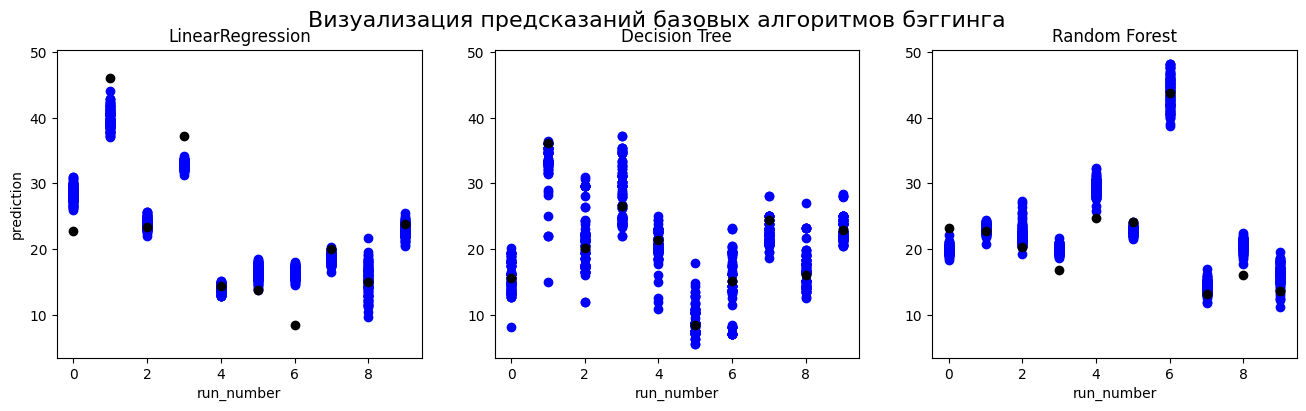

In [11]:
plt.figure(figsize=(16, 4))
plt.suptitle("Визуализация предсказаний базовых алгоритмов бэггинга", fontsize=16)
ax = plt.subplot(131)
plt.xlabel('run_number')
plt.ylabel('prediction')
plot_predictions(LinearRegression(), X, y, title='LinearRegression')

plt.subplot(132, sharey=ax)
plt.xlabel('run_number')
plot_predictions(DecisionTreeRegressor(), X, y, title='Decision Tree')

plt.subplot(133, sharey=ax)
plt.xlabel('run_number')
plot_predictions(RandomForestRegressor(), X, y, title='Random Forest')

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__
1) Видим, что лин регрессия имеет большее смещение, средние предсказания располагаются очень далеко от правильного ответа

2) Решающее дерево имеет меньшее смещение (среднее предсказание лежит близко к правильному ответу), но разброс очень большой, поэтому отдельные предсказания могут значительно различатся
   
3) Случайный лес имеет меньшее смещение чем линейная регрессия, но чуть больший разброс 

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

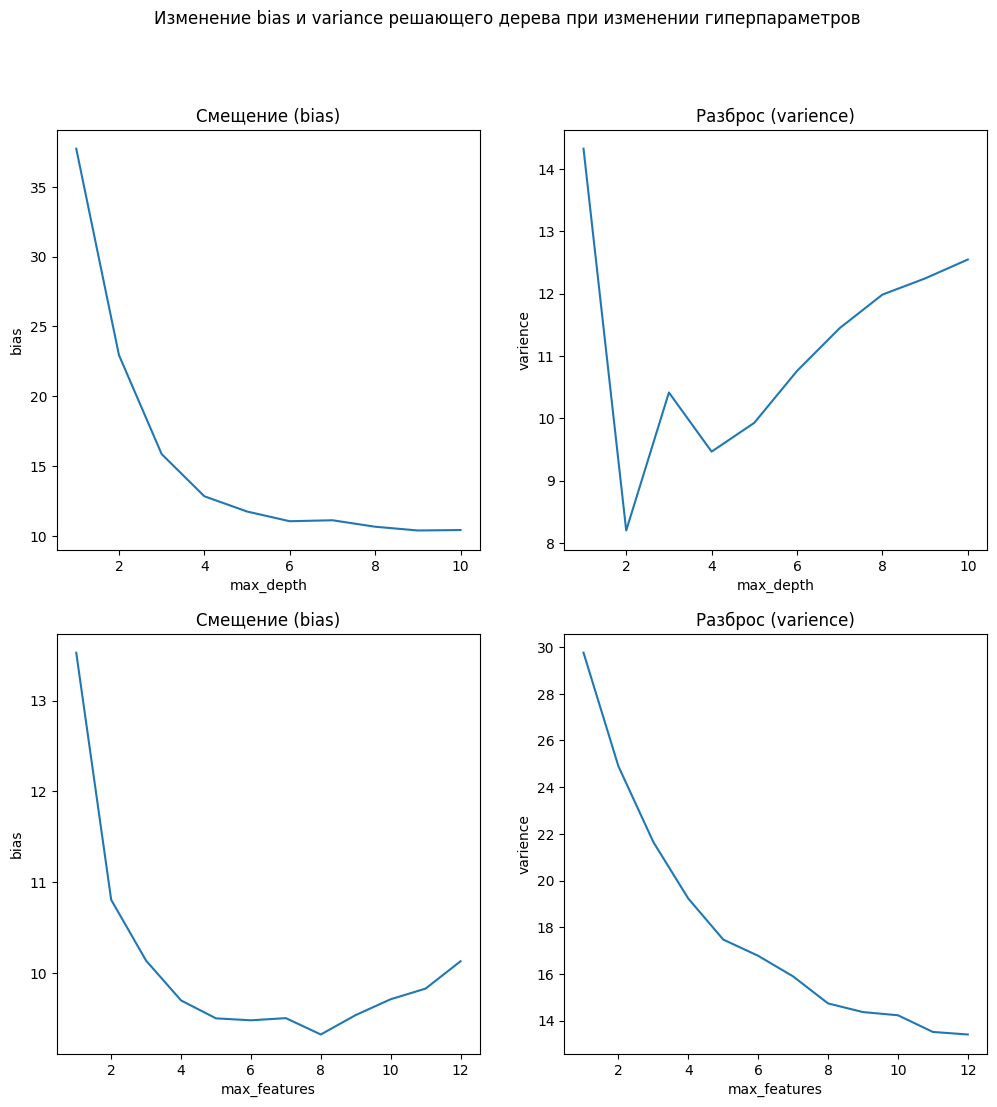

In [19]:
plt.figure(figsize=(12, 12))
plt.suptitle("Изменение bias и variance решающего дерева при изменении гиперпараметров")
# max_depth
bias = []
varience = []
for i in range(1, 11):
    b, v, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=i), X, y, num_runs=1000)
    bias += [b]
    varience += [v]
plt.subplot(2, 2, 1)
plt.title("Смещение (bias)")
plt.xlabel("max_depth")
plt.ylabel("bias")
plt.plot(np.arange(1, 11), bias)

plt.subplot(2, 2, 2)
plt.title("Разброс (varience)")
plt.yticks(label='Varience')
plt.ylabel("varience")
plt.xlabel("max_depth")
plt.plot(np.arange(1, 11), varience)

# max_features
bias = []
varience = []
for i in range(1, X.shape[1]):
    b, v, _ = compute_biase_variance(DecisionTreeRegressor(max_features=i), X, y, num_runs=1000)
    bias += [b]
    varience += [v]
plt.subplot(2, 2, 3)
plt.title("Смещение (bias)")
plt.xlabel("max_features")
plt.ylabel("bias")
plt.plot(np.arange(1, X.shape[1]), bias)

plt.subplot(2, 2, 4)
plt.title("Разброс (varience)")
plt.yticks(label='Varience')
plt.ylabel("varience")
plt.xlabel("max_features")
plt.plot(np.arange(1, X.shape[1]), varience)
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

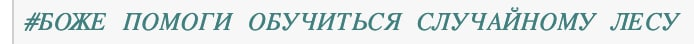

**Н** Он обучался 35 минут (и это у меня еще мощный ноут...)

Estimated time: -2089.636990


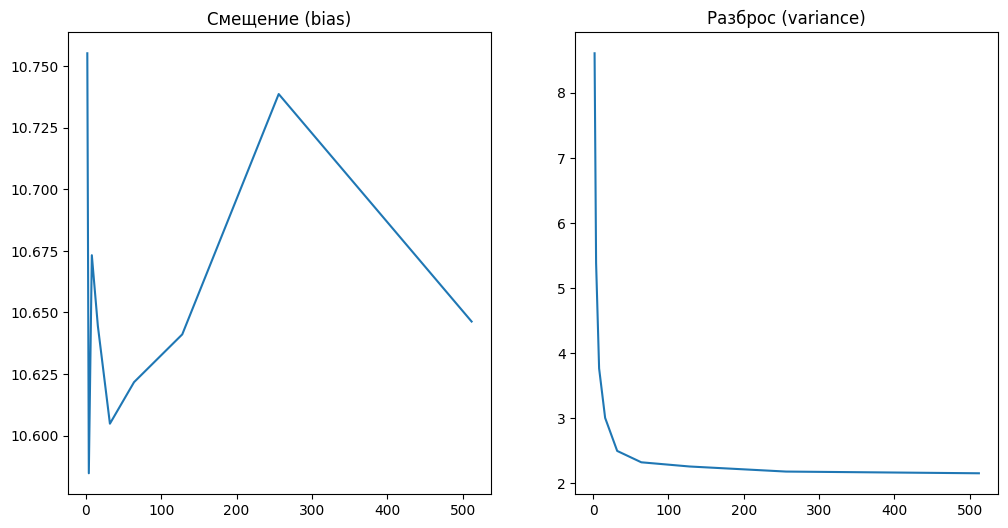

In [54]:
start_time = time.time()

plt.figure(figsize=(12, 6))
bias = []
varience = []
for i in 2**np.arange(1, 10):
    b, v, _ = compute_biase_variance(RandomForestRegressor(n_estimators=i), X, y, num_runs=1000)
    bias += [b]
    varience += [v]
plt.subplot(1, 2, 1)
plt.title("Смещение (bias)")
plt.plot(2**np.arange(1, 10), bias)

plt.subplot(1, 2, 2)
plt.title("Разброс (variance)")
plt.plot(2**np.arange(1, 10), varience)

print("Estimated time: %f" % (time.time() - start_time))

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

1) Видим, что изначально смещение модели решающего дерева быстро падает, но уже при глубине > 3, падение замедляется, разброс же резко падает с 1 до 2 и далее начинает расти, так как дерево начинает переобучатся отсюда и возникает метод локтя (elbow method), т.е. смотрим когда смещение перестает значительно снижатся и берем данный гиперпараметр
2) Для случайного леса видим почти противоположную картину, разброс очень быстро уменьшается а смещение после числа деревьев=32 начинает постепенно расти, хоть потом и будет падать, хотя при этом все равно его изменение составляет не более 0.1, в итоге оптимальным выглядит взять 32 дерева

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

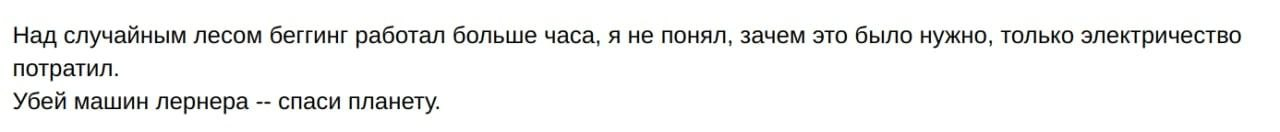